
# <center>Replicating The Models and Findings of Indonesian GDP Growth Forecasting</center>
<center>Emmanuel Wullur</center>

#### Overview
Basically there are two purpose of this notebook:
1) I wished to replicate the result and modelling process of a time series forecasting paper entitled __Penerapan Time Series Forecasting untuk Memprediksi Pertumbuhan Ekonomi Indonesia 2024__ ([doi](https://doi.org/10.47709/dsi.v3i2.3263)) by Muhtar et al. (2023).
2) I attempted to critically evaluate the paper and, if possible, improve the model.

#### Reference Paper Overview
The study, henceforth called "the paper",  aimed to forecast Indonesian annual real Gross Domestic Product (GDP) growth in 2024 given quarterly GDP data from Q1 2014 to Q3 2023. The modeling process involves these 6 process:
1. Tentative identification for stationarity and model selection;
2. Modeling the data using ARIMA
4. Diagnosing the best ARIMA model;
5. Modeling the data using SARIMA;
7. Diagnosing the best SARIMA Model;
9. Forecasting the GDP using the best model.

The final model is a $SARIMA(2,1,2)(1,0,0)^4$ which predicts a $3.2456\%$ growth. 

#### Data Source
To obtain the same data as that of the paper, I scraped the GDP data from Badan Pusat Statistik (BPS)'s webpage entitled "\[Seri 2010] PDB Menurut Lapangan Usaha Seri 2010 (Milyar Rupiah), 2024" ([link](https://www.bps.go.id/id/statistics-table/2/NjUjMg==/-seri-2010--pdb-seri-2010--milyar-rupiah-.html)).

# Importing Libraries and Data

In [48]:
# The essentials data analysis package
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# For exploratory analysis and charts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# For modeling
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For auto modeling and hyperparametric tuning
import pmdarima as pm

# Not a widely acceptable practice, but im doing it anyway :p
import warnings
warnings.filterwarnings("ignore")

In [49]:
df = pd.read_excel("gdp_2010_2024.xlsx")
df.head(3)

,Industri,Subindustri,Subsubindustri,real_2010_q1,real_2010_q2,real_2010_q3,real_2010_q4,real_2010_total,nominal_2010_q1,nominal_2010_q2,...,real_2024_q1,real_2024_q2,real_2024_q3,real_2024_q4,real_2024_total,nominal_2024_q1,nominal_2024_q2,nominal_2024_q3,nominal_2024_q4,nominal_2024_total
0,"Pertanian, Kehutanan, dan Perikanan",NaN,NaN,225677.1,243260.6,270493.9,216688.1,956119.7,219047.6,241215.9,...,327093.5,403730.8,404124.1,-,-,613806.3,762654.5,773241.0,-,-
1,NaN,"Pertanian, Peternakan, Perburuan dan Jasa Pert...",NaN,179132.0,192128.1,218186.7,164987.6,754434.4,173189.5,190925.6,...,246800.0,313919.5,311257.6,-,-,459852.1,589783.4,594459.3,-,-
2,NaN,NaN,Tanaman Pangan,75284.1,68696.0,67224.8,42121.7,253326.6,74693.5,67316.2,...,58907.8,99607.2,77653.5,-,-,101843.6,166752.8,130743.5,-,-


## Data Cleaning

In [50]:
# Filter by GDP row only
df_gdp = (df.loc[df["Industri"]=="PRODUK DOMESTIK BRUTO", :]
          .drop(["Subindustri", "Subsubindustri"], axis=1))

# Filter by real GDP Q1 2014 to Q3 2023. There is a more straightforward way,
# but i am trying to make the whole process repeatable when given new data
cols = df_gdp.columns
real_2014_2023_cols = ([i for i in cols if i.startswith("real_") 
                        and (not i.startswith("real_2024_")) 
                        and (not i.endswith("total"))
                        and (not i=="real_2023_q4")
                        and (not i.startswith("real_2010"))
                        and (not i.startswith("real_2011"))
                        and (not i.startswith("real_2012"))
                        and (not i.startswith("real_2013"))])

# Transpose and change column names
df_gdp_real_2014_2023 = df_gdp[real_2014_2023_cols].T.reset_index()
df_gdp_real_2014_2023.columns = ["period", "gdp"]

# Convert period column to datetime
period_split = df_gdp_real_2014_2023["period"].str.split("_", expand=True)
df_gdp_real_2014_2023["period"] = (pd.to_datetime(period_split[1] + period_split[2].str.upper())
                                   .dt.to_period("Q"))

In [51]:
# Clean data
df_gdp_real_2014_2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   period  39 non-null     period[Q-DEC]
 1   gdp     39 non-null     float64      
dtypes: float64(1), period[Q-DEC](1)
memory usage: 756.0 bytes


# Preliminary Evaluation of the Paper Model
At the time of writing, the most recent available data on the GDP is on Q32024, meaning I can evaluate the model on the paper for 4 time periods, from Q3 2023 - Q4 2024.

### Constructing the test dataset

In [52]:
cols = df_gdp.columns
real_2023q4_2024q3_cols =['real_2023_q4', 'real_2024_q1', 'real_2024_q2', 'real_2024_q3']

df_test = df_gdp[real_2023q4_2024q3_cols].T.reset_index()
df_test.columns = ["period", "gdp"]

# Convert period column to datetime
period_split = df_test["period"].str.split("_", expand=True)
df_test["period"] = (pd.to_datetime(period_split[1] + period_split[2].str.upper())
                     .dt.to_period("Q"))
df_test

,period,gdp
0,2023Q4,3139084.5
1,2024Q1,3113016.8
2,2024Q2,3230967.8
3,2024Q3,3279593.4


In [53]:
# The predicted GDP value from the paper (in order)
paper_prediction = [3111273, 3205135, 3146260, 3215504]

### Evaluation

In [54]:
# Function to get metrics for time series evaluation, courtesy of ChatGPT :D
def compute_metrics(y_true, y_pred):
    """
    Compute MAE, MSE, RMSE, R-squared, and MAPE between true and predicted values.

    Parameters:
        y_true (array-like): True values.
        y_pred (array-like): Predicted values.

    Returns:
        dict: Dictionary containing MAE, MSE, RMSE, R-squared, and MAPE.
    """
    # Convert inputs to NumPy arrays for consistency
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate metrics
    mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
    mse = np.mean((y_true - y_pred) ** 2)   # Mean Squared Error
    rmse = np.sqrt(mse)                     # Root Mean Squared Error
    
    # Avoid division by zero for MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.all(y_true) else np.inf
    
    # Calculate R-squared
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)  # Total Sum of Squares
    ss_residual = np.sum((y_true - y_pred) ** 2)       # Residual Sum of Squares
    r_squared = 1 - (ss_residual / ss_total) if ss_total != 0 else np.nan  # Handle constant y_true
    
    # Return metrics as a dictionary
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R-squared": r_squared, "MAPE": mape}

In [55]:
# Metrics evaluation
real_gdp = df_test["gdp"].values
paper_model_metrics = compute_metrics(real_gdp, paper_prediction)
paper_model_metrics

{'MAE': 67181.72499999998,
 'MSE': 5135526219.172498,
 'RMSE': 71662.58590905367,
 'R-squared': -0.12730167962933026,
 'MAPE': 2.105259688087723}

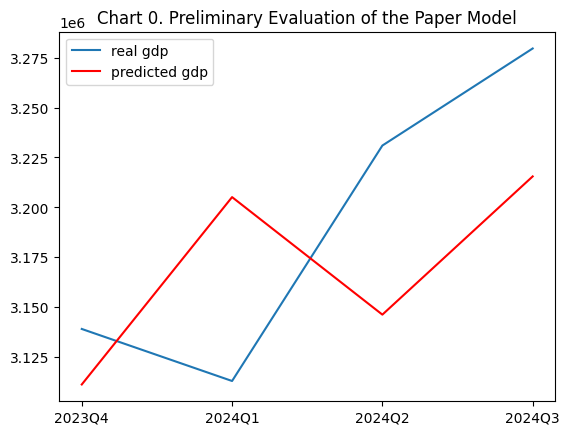

In [56]:
fig, ax = plt.subplots()
x_axis = df_test["period"].astype("str")

ax.plot(x_axis, real_gdp, label="real gdp")
ax.plot(x_axis, paper_prediction, label="predicted gdp", color="red")
ax.set_title("Chart 0. Preliminary Evaluation of the Paper Model")
ax.legend()

plt.show()

Visually, the model does not perform particularly well on 2023Q4 to 2024Q1, but it starts picking up on the right track after 2024Q2. As a disclaimer, I am not claiming that the model is inaccurate, especially considering that the point of time series is not just to achieve correct forecast. Nevertheless, I will try to get a better metrics result in the forecast.

# Data Exploration
Performing Exploratory Data Analysis and trying to see which model is the most approriate.

### GDP Visualization

#### GDP Across Time
This one is figure 5 on the paper

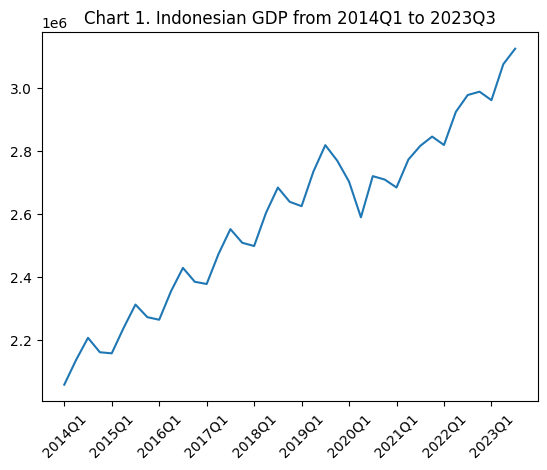

In [112]:
fig, ax = plt.subplots()

x = df_gdp_real_2014_2023["period"].astype("str") # matplotlib doesnt suppport period dtype
y = df_gdp_real_2014_2023["gdp"]

ax.plot(x, y)
ax.set_xticks(ticks=x.values[::4], labels=x.values[::4], rotation=45)  # Show every 4th label
ax.set_title("Chart 1. Indonesian GDP from 2014Q1 to 2023Q3")

plt.show()

#### Growth visualization

To see more visually, heres the annual growth rate. Also, for curiosity sake, the BI interest rate is overlaid. Note that the BI Rate started from Aug 2016, from then on BI started using a new rate named bi 7 day reverse repo rate.

In [58]:
df_bi_rate = pd.read_excel("bi_rate_2016_2024.xlsx")
df_bi_rate = df_bi_rate.iloc[:, 1:].T.reset_index()
df_bi_rate = df_bi_rate[(df_bi_rate["index"]<"2024-12-01") & (df_bi_rate["index"]>"2016-07-01")]
df_bi_rate[0] = df_bi_rate[0].str.replace(",", ".").astype("float")
df_bi_rate.columns = ["period", "bi_rate"]

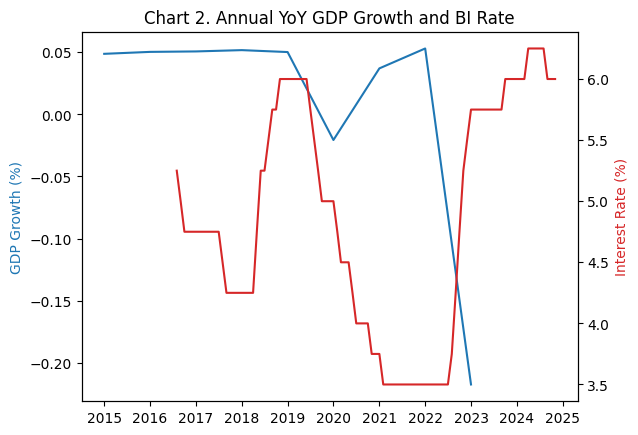

In [113]:
# Resample to yearly data
df_gdp_real_2014_2023_change = df_gdp_real_2014_2023.set_index("period").resample("Y").sum().pct_change()

fig, ax1 = plt.subplots()

x_gdp_growth = df_gdp_real_2014_2023_change.index.to_timestamp()
y_gdp_growth = df_gdp_real_2014_2023_change["gdp"]

x_bi_rate = df_bi_rate["period"]
y_bi_rate = df_bi_rate["bi_rate"]

ax2 = ax1.twinx()  # Instantiate a second y-axis sharing the same x-axis

ax1.plot(x_gdp_growth, y_gdp_growth, color="tab:blue", label="GDP Growth")
ax2.plot(x_bi_rate, y_bi_rate, color="tab:red", label="BI Rate")

ax1.set_ylabel('GDP Growth (%)', color='tab:blue')
ax2.set_ylabel('Interest Rate (%)', color='tab:red')

plt.title("Chart 2. Annual YoY GDP Growth and BI Rate")
plt.show()

You can see the trend thats felt by nearly the entire world, i.e. the interest rate plummeted during the pandemic to stimulate growth, but then skyrocketed to stop raging inflation.

### Stationarity Checking
I could not replicate the exact numbers of the ADF in level test found on the paper (table 1). I tried every ADF model combination and found the closest and most plausible model to be a constant + linear trend with 1 lag, which makes a lot of sense, considering that the GDP plot looks relatively linear (Chart 1).

#### ADF Fuller Test in level for Unit Roots

In [60]:
# Available combination model for the ADF test
lag = range(1, 39)
reg = ["c", "ct", "ctt", "n"]

all_values = []

for rg in reg:
    for lg in lag:
        try:
            result = adfuller(df_gdp_real_2014_2023["gdp"].values, 
                              regression=rg, maxlag=lg, autolag=None)
            t_stat = result[0]
            p_val = result[1]
            all_values.append([rg, lg, t_stat, p_val])
            
        # accounting for when maxlag outnumbers the available parameters
        except ValueError: 
            continue

df_result = pd.DataFrame(all_values,columns=["reg", "lag", "t_stat", "p_val"])
df_result.sort_values("p_val").head()

,reg,lag,t_stat,p_val
17,ct,1,-3.563515,0.033070
33,ctt,1,-3.490285,0.115392
21,ct,5,-2.660556,0.252822
45,ctt,13,-2.829210,0.382386
14,c,15,-1.778881,0.390996


#### ACF and PACF Plot in level
I managed to get the exact numbers on the paper (Figure 2) by using the _Yule-Walker without adjustment_ method on the PACF.

In [61]:
max_lag = 16
lag_acf = acf(df_gdp_real_2014_2023["gdp"], nlags=max_lag)
lag_pacf = pacf(df_gdp_real_2014_2023["gdp"], nlags=max_lag,
                method="ywm")

dict_acf_pacf = {"lag": range(max_lag+1),
                 "acf": lag_acf,
                 "pacf": lag_pacf}

pd.DataFrame(dict_acf_pacf).head()

,lag,acf,pacf
0,0,1.000000,1.000000
1,1,0.878192,0.878192
2,2,0.771139,-0.000363
3,3,0.716761,0.173204
4,4,0.644686,-0.088004


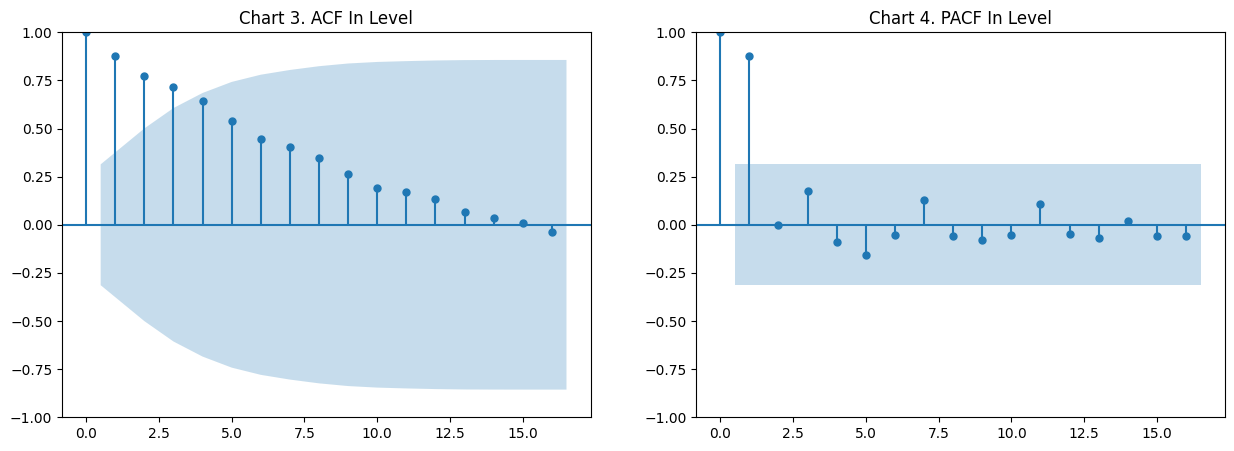

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(df_gdp_real_2014_2023["gdp"], ax=ax[0])
ax[0].set_title("Chart 3. ACF In Level")

plot_pacf(df_gdp_real_2014_2023["gdp"], ax=ax[1], method="ywm")
ax[1].set_title("Chart 4. PACF In Level")

plt.show()

Clearly, the data is not stationarity in level.

# Data Transformation to Induce Stationarity

## Taking First Difference

In [63]:
df_gdp_real_2014_2023_diff = df_gdp_real_2014_2023.copy()
df_gdp_real_2014_2023_diff["gdp_1_diff"] = (df_gdp_real_2014_2023["gdp"] 
                                     - df_gdp_real_2014_2023.shift(1)["gdp"])
df_gdp_real_2014_2023_diff = df_gdp_real_2014_2023_diff.dropna()
df_gdp_real_2014_2023_diff.head()

,period,gdp,gdp_1_diff
1,2014Q2,2137385.6,78800.7
2,2014Q3,2207343.6,69958.0
3,2014Q4,2161552.5,-45791.1
4,2015Q1,2158040.0,-3512.5
5,2015Q2,2238704.4,80664.4


### Stationarity After First Differencing

#### ADF Test
Using the same ADF model specification as the previous one, I managed to get relatively close numbers to ones in the paper (Table 2)

In [64]:
result = adfuller(df_gdp_real_2014_2023_diff["gdp_1_diff"], 
                  regression="ct", maxlag=1, autolag=None)
print(f"p_value: {result[1]}")
print(f"t_stats: {result[0]}")

p_value: 1.2717046816719628e-11
t_stats: -8.324539524817839


We reject the hypothesis that the first differenced time series has unit root.

#### ACF and PACF Plot After Differencing
Using the same PACF method as above, I can duplicate figure 3.

In [65]:
max_lag = 16
lag_acf = acf(df_gdp_real_2014_2023_diff["gdp_1_diff"], nlags=max_lag)
lag_pacf = pacf(df_gdp_real_2014_2023_diff["gdp_1_diff"], nlags=max_lag,
                method="ywm")

dict_acf_pacf = {"lag": range(max_lag+1),
                 "acf": lag_acf,
                 "pacf": lag_pacf}

pd.DataFrame(dict_acf_pacf).head()

,lag,acf,pacf
0,0,1.000000,1.000000
1,1,-0.027998,-0.027998
2,2,-0.580324,-0.581564
3,3,-0.068465,-0.167020
4,4,0.555637,0.310338


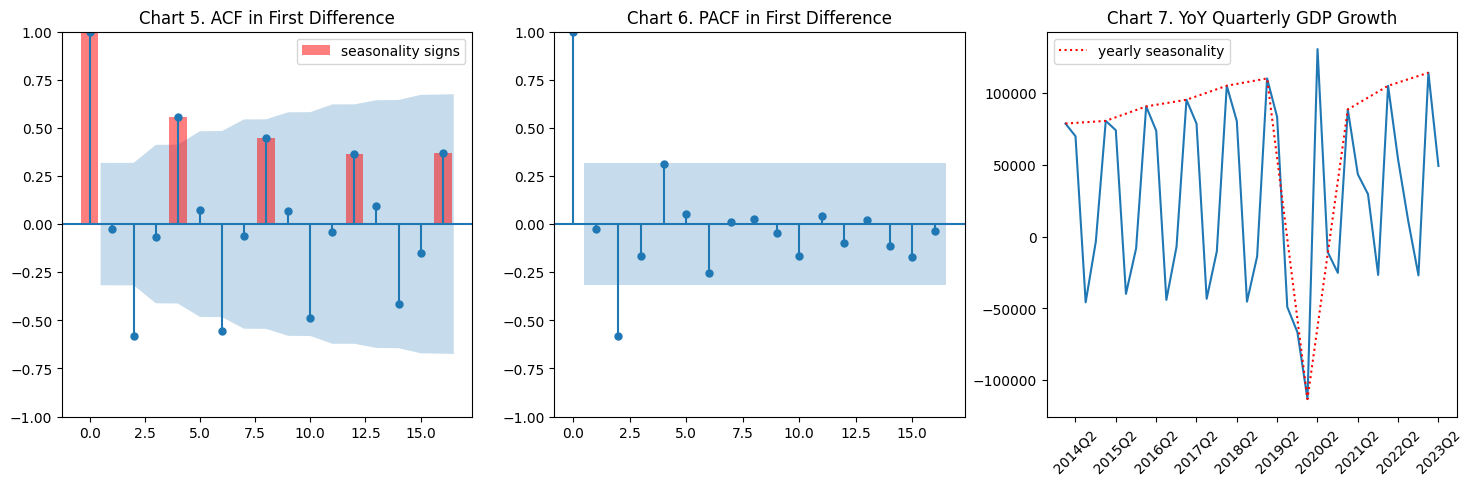

In [66]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))


# Ax 0
plot_acf(df_gdp_real_2014_2023_diff["gdp_1_diff"], ax=ax[0])
ax[0].set_title("Chart 5. ACF in First Difference")
ax[0].bar(range(0, 17, 4), acf(df_gdp_real_2014_2023_diff["gdp_1_diff"], nlags=16)[::4], 
           color="red", label="seasonality signs", alpha=0.5)
ax[0].legend()

# Ax 2
plot_pacf(df_gdp_real_2014_2023_diff["gdp_1_diff"], ax=ax[1],
          method="ywm")
ax[1].set_title("Chart 6. PACF in First Difference")

# Ax 2
ax[2].plot(df_gdp_real_2014_2023_diff["period"].dt.to_timestamp(), 
           df_gdp_real_2014_2023_diff["gdp_1_diff"])
ax[2].plot(df_gdp_real_2014_2023_diff["period"].dt.to_timestamp()[::4], 
           df_gdp_real_2014_2023_diff["gdp_1_diff"][::4], color="red", 
           label="yearly seasonality", linestyle ="dotted")
ax[2].legend()
ax[2].set_xticks(ticks=df_gdp_real_2014_2023_diff["period"][::4],
                 labels=df_gdp_real_2014_2023_diff["period"][::4],
                 rotation=45)
ax[2].set_title("Chart 7. YoY Quarterly GDP Growth")


plt.show()

Looking at the ACF (Chart 5), there is clear seasonality every quarter (every 4th lag). The ADF test only measures the presence the unit root, the lack thereof is arguably not sufficient for stationarity. This brings us the question of whether the first difference is actually stationary. For reminder, here is the second order stationary definition. A time series $X_{t}$ is stationary if and only if the following conditions hold:

1. **Constant Mean**:  
$E[X_t] = \mu \quad \text{for all } t,$
where $\mu$ is a constant.

3. **Constant Variance**:  
$\text{Var}(X_t) = \sigma^2 \quad \text{for all } t,$
where $\sigma^2$ is a constant.

4. **Autocovariance Depends Only on Lag**:  
$\text{Cov}(X_t, X_{t+h}) = \gamma(h) \quad \text{for all } t \text{ and lag } h,$
where $\gamma(h)$ is the autocovariance function that depends only on the lag $h$.


While the presence of seasonality may or may not immediately imply non-seasonality (debates on the subject can be seen on [here](https://stats.stackexchange.com/questions/131092/does-a-seasonal-time-series-imply-a-stationary-or-a-non-stationary-time-series?noredirect=1&lq=1) and [here](https://stats.stackexchange.com/questions/438303/can-a-time-series-be-stationary-and-still-have-seasonality?noredirect=1&lq=1)), an upward trend in seasonality (seen on chart 7) is definitely a sign of non-stationarity as it violates the constant mean condition. This indicates the need to do seasonality differencing.

## Taking Seasonal Differencing
I want to look at whether stationarity is achieved after seasonal differencing

In [67]:
df_gdp_real_2014_2023_diff_season = df_gdp_real_2014_2023_diff.copy()
# Seasonal difference
df_gdp_real_2014_2023_diff_season["gdp_season_diff"] = (df_gdp_real_2014_2023_diff["gdp"] 
                                                        - df_gdp_real_2014_2023_diff["gdp"].shift(4))
# First difference on the seasonal difference
df_gdp_real_2014_2023_diff_season["gdp_season_diff_1_diff"] = (df_gdp_real_2014_2023_diff_season["gdp_season_diff"] 
                                                               - df_gdp_real_2014_2023_diff_season["gdp_season_diff"].shift(1))
df_gdp_real_2014_2023_diff_season = df_gdp_real_2014_2023_diff_season.dropna()

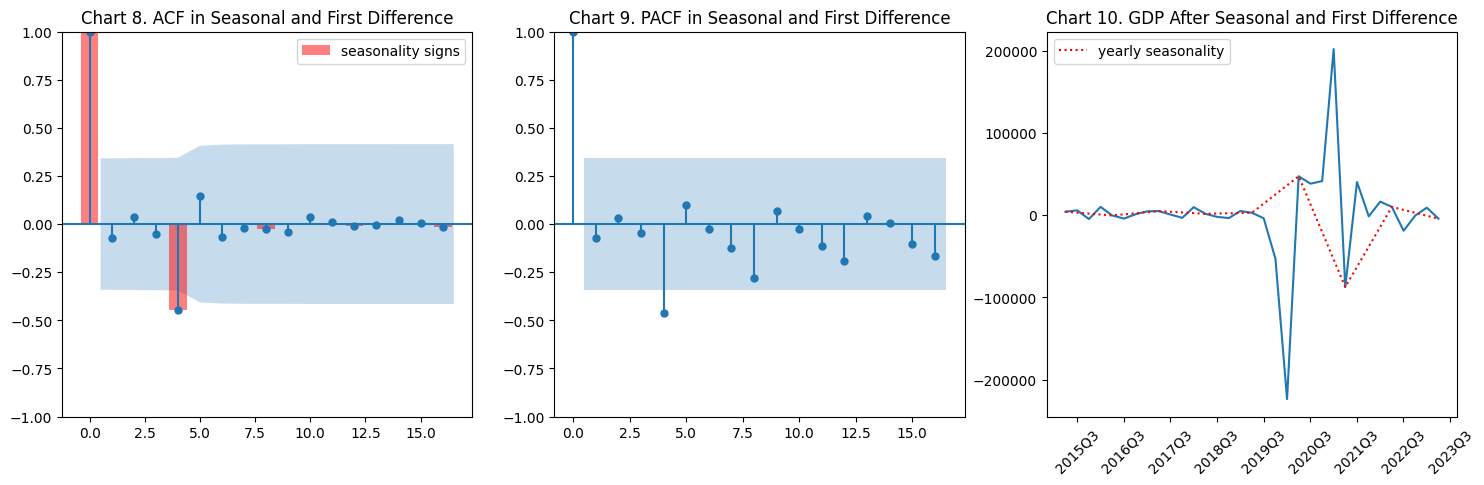

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))


# Ax 0
plot_acf(df_gdp_real_2014_2023_diff_season["gdp_season_diff_1_diff"], ax=ax[0])
ax[0].set_title("Chart 8. ACF in Seasonal and First Difference")
ax[0].bar(range(0, 17, 4), acf(df_gdp_real_2014_2023_diff_season["gdp_season_diff_1_diff"], nlags=16)[::4], 
           color="red", label="seasonality signs", alpha=0.5)
ax[0].legend()

# Ax 2
plot_pacf(df_gdp_real_2014_2023_diff_season["gdp_season_diff_1_diff"], ax=ax[1],
          method="ywm")
ax[1].set_title("Chart 9. PACF in Seasonal and First Difference")

# Ax 2
ax[2].plot(df_gdp_real_2014_2023_diff_season["period"].dt.to_timestamp(), 
           df_gdp_real_2014_2023_diff_season["gdp_season_diff_1_diff"])
ax[2].plot(df_gdp_real_2014_2023_diff_season["period"].dt.to_timestamp()[::4], 
           df_gdp_real_2014_2023_diff_season["gdp_season_diff_1_diff"][::4], color="red", 
           label="yearly seasonality", linestyle ="dotted")
ax[2].legend()
ax[2].set_xticks(ticks=df_gdp_real_2014_2023_diff_season["period"][::4],
                 labels=df_gdp_real_2014_2023_diff_season["period"][::4],
                 rotation=45)
ax[2].set_title("Chart 10. GDP After Seasonal and First Difference")


plt.show()

Despite the spike during covid years, now it looks much more stationary compared to just first difference, making the case for SARIMA process.

# Modeling
Based on the EDA, SARIMA is certainly most approriate model, but ARIMA will be modeled to replicate the paper modeling process. To get the best ARIMA and SARIMA model, I will use auto time series implemented by pmdarima package in python.

In [69]:
train = df_gdp_real_2014_2023["gdp"]

## ARIMA

In [70]:
auto_arima = pm.arima.auto_arima(y=train, seasonality=False, trace=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=950.956, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=952.403, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=954.477, Time=0.03 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=955.249, Time=0.04 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=957.500, Time=0.03 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=959.157, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=952.375, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=954.392, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=956.391, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=957.237, Time=0.13 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=959.498, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=962.295, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=959.840, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept

The paper did not state any transformation done on the data before modeling. However, when i fit the data even using the best parameter found on the paper $ARIMA(2,1,0)$, the coefficients do not converge. As far as i am aware, Eviews, software used in the paper also considers using a log transformation. Therefore, I will try using a log transformation.

In [71]:
train_log = np.log(df_gdp_real_2014_2023["gdp"])

In [72]:
# The default specification is d=1 to account for first difference
auto_arima = pm.arima.auto_arima(y=train_log, d=1, seasonality=False, trace=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-170.654, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-168.581, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-178.298, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-176.804, Time=0.21 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-177.833, Time=0.19 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-176.026, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-168.671, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-169.231, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-176.320, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-174.678, Time=0.21 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-175.836, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-186.082, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-184.581, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-192.207, Time=0.47 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-193.564, Time=0.26 sec
 ARIMA(3,1

Now the best model found is indeed as stated in the paper. However, the AIC value is way off.

## SARIMA
The paper does not use auto time series for the SARIMA, but instead follows the ARIMA order. But let's try auto sarima anyway.

In [73]:
# The default specification is d=1 and 4 to account for first and seasonality difference
auto_arima = pm.arima.auto_arima(y=train_log, d=1, seasonality=True, m=4, trace=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-170.654, Time=0.01 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=-178.417, Time=0.07 sec
 ARIMA(0,1,0)(0,0,2)[4] intercept   : AIC=-180.977, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=-185.841, Time=0.09 sec
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=-189.313, Time=0.10 sec
 ARIMA(0,1,0)(1,0,2)[4] intercept   : AIC=-188.235, Time=0.26 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=-187.103, Time=0.14 sec
 ARIMA(0,1,0)(2,0,1)[4] intercept   : AIC=-187.862, Time=0.25 sec
 ARIMA(0,1,0)(2,0,2)[4] intercept   : AIC=-186.107, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-168.581, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-177.141, Time=0.18 sec
 ARIMA(0,1,1)(0,0,2)[4] intercept   : AIC=-179.284, Time=0.21 sec
 ARIMA(0,1,1)(1,0,0)[4] intercept   : AIC=-184.198, Time=0.13 sec
 ARIMA(0,1,1)(1,0,1)[4] intercept   : AIC=-187.675, Time=0.16 sec
 ARIMA(0,1,1)(1,0,2)[4] intercept   : AIC=-184.743, Time=0.33 sec
 ARIMA(0,1

Interestingly, the best SARIMA model is really no seasonality at all. This might be caused by the spikes during covid years, which messes with the seasonality. Nevertheless, the data is in fact, seasonal, hence SARIMA will still be approriate. I will try to replicate the SARIMA combinations evaluation found on the paper (Table 4).

It appeared that one SARIMA combination in the paper, in its default value, will not converge (even after log transformation). Therefore, I am taking the liberty to normalize the data using z-score.

In [74]:
train_norm = (train - train.mean())/train.std()

In [75]:
non_seasonal_order = [2, 1, 2]
seasonal_orders = [[1, 0, 0, 4], [1, 0, 1, 4], [0, 0, 1, 4]]

evaluation = []
models = []

for sea_ord in seasonal_orders:
    model = SARIMAX(train_norm, order=non_seasonal_order, seasonal_order=sea_ord)
    model_fit = model.fit(maxiter=100)
    aic = model_fit.aic
    evaluation.append([non_seasonal_order, sea_ord, aic])
    models.append(model_fit)

df_sarima_evaluation = pd.DataFrame(evaluation, columns=["non-seasonal order", "seasonal order", "AIC"])

In [76]:
df_sarima_evaluation

,non-seasonal order,seasonal order,AIC
0,"[2, 1, 2]","[1, 0, 0, 4]",-14.956460
1,"[2, 1, 2]","[1, 0, 1, 4]",-16.553481
2,"[2, 1, 2]","[0, 0, 1, 4]",-14.401174


interestingly, the best model in terms of AIC is different than that of the paper. I am curious as to the difference between my approach and that of the paper, but i havent quite uncover it. In the end, the following is my final model.

In [77]:
best_model = models[1]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 gdp   No. Observations:                   39
Model:             SARIMAX(2, 1, 2)x(1, 0, [1], 4)   Log Likelihood                  15.277
Date:                             Sat, 04 Jan 2025   AIC                            -16.553
Time:                                     13:27:24   BIC                             -5.090
Sample:                                          0   HQIC                           -12.475
                                              - 39                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0275      0.476      0.058      0.954      -0.906       0.961
ar.L2         -0.9815      0.517     -1.898      0.058      -1.995       0.032
ma.L1          0.0581      0.543      0.107      0.915      -1.007       1.123
ma.L2          0.9863      3.547      0.278      0.781      -5.965       7.938
ar.S.L4        0.9994      0.133      7.513      0.000       0.739       1.260
ma.S.L4       -0.9721      2.918     -0.333      0.739      -6.692       4.747
sigma2         0.0202      0.071      0.286      0.775      -0.118       0.159
===================================================================================
Ljung-Box (L1) (Q):                   1.06   Jarque-Bera (JB):               223.22
Prob(Q):                              0.30   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                            -2.61
Prob(H) (two-sided):                  0.14   Kurtosis:                        13.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Diagnosing the best model

### Normality of the Residuals

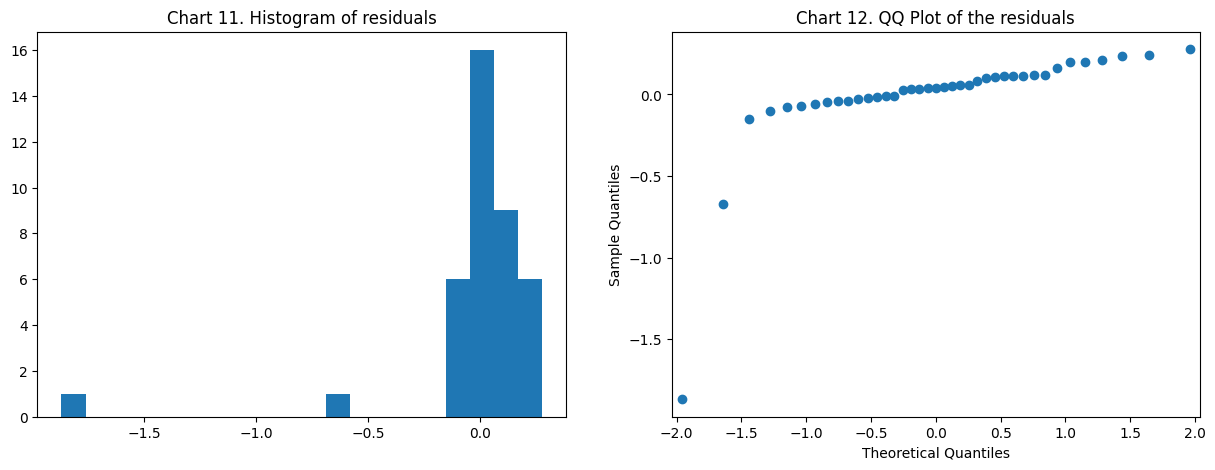

In [78]:
residuals = best_model.resid

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(residuals, bins=20)
ax[0].set_title("Chart 11. Histogram of residuals")

sm.qqplot(residuals, ax=ax[1])
ax[1].set_title("Chart 12. QQ Plot of the residuals")

plt.show()

In [79]:
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuals)
print(f"Jarque-Bera Statistic: {jb_stat}")
print(f"p-value: {jb_pvalue}")

Jarque-Bera Statistic: 836.8433631212368
p-value: 1.913253821892846e-182


Clearly the residual is not normally distributed, which violates assumption about the error term. The paper found similar result but ignores it by invoking the Central Limit Theorem, claiming that sample size is large enough to ensure the normality of the error sampling distribution. I tend to follow suit as the t-test and other test used are supposed to be robust against certain violation of normality, especially for large enough sample.

### Testing for White Noise of Residuals

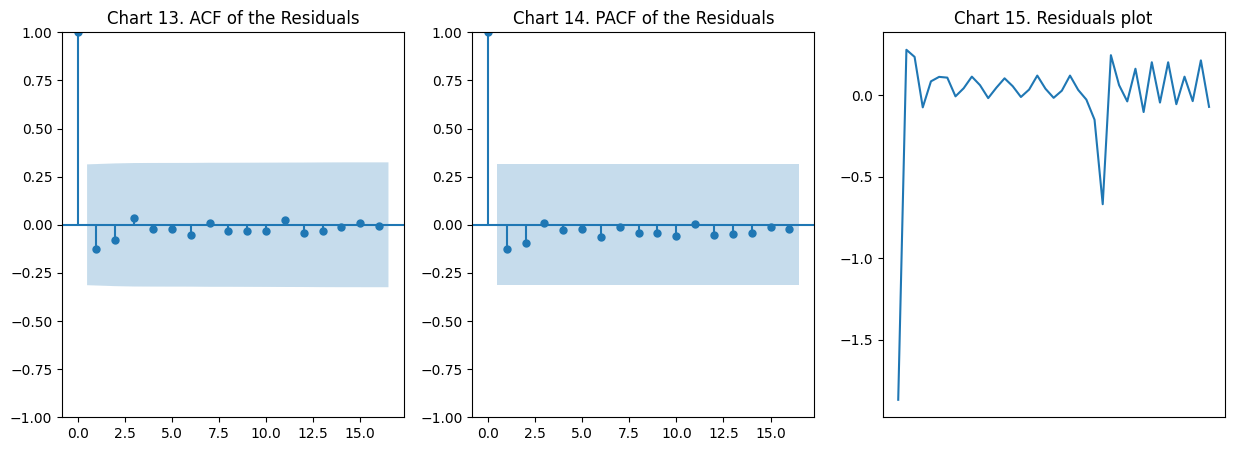

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

plot_acf(residuals, ax=ax[0])
ax[0].set_title("Chart 13. ACF of the Residuals")

plot_pacf(residuals, ax=ax[1])
ax[1].set_title("Chart 14. PACF of the Residuals")

ax[2].plot(residuals)
ax[2].set_title("Chart 15. Residuals plot")
ax[2].set_xticks([])

plt.show()


Barring the outliers, residuals look relatively white noise.

# Evaluation on Novel Data
Time to evaluate my model and compare its performance to that of the paper.

In [81]:
# Forecast my model and return it to its original scale
prediction_5_step = (best_model.forecast(steps=5) * train.std()) + train.mean()
my_prediction = prediction_5_step[:-1]

In [82]:
my_model_metrics = compute_metrics(my_prediction, real_gdp)

pd.DataFrame([my_model_metrics.values(), paper_model_metrics.values()], 
             columns=my_model_metrics.keys(),
             index=["mine", "paper"])

,MAE,MSE,RMSE,R-squared,MAPE
mine,53586.00632,3.422650e+09,58503.418544,-0.426990,1.700392
paper,67181.72500,5.135526e+09,71662.585909,-0.127302,2.105260


In [103]:
real_gdp

array([3139084.5, 3113016.8, 3230967.8, 3279593.4])

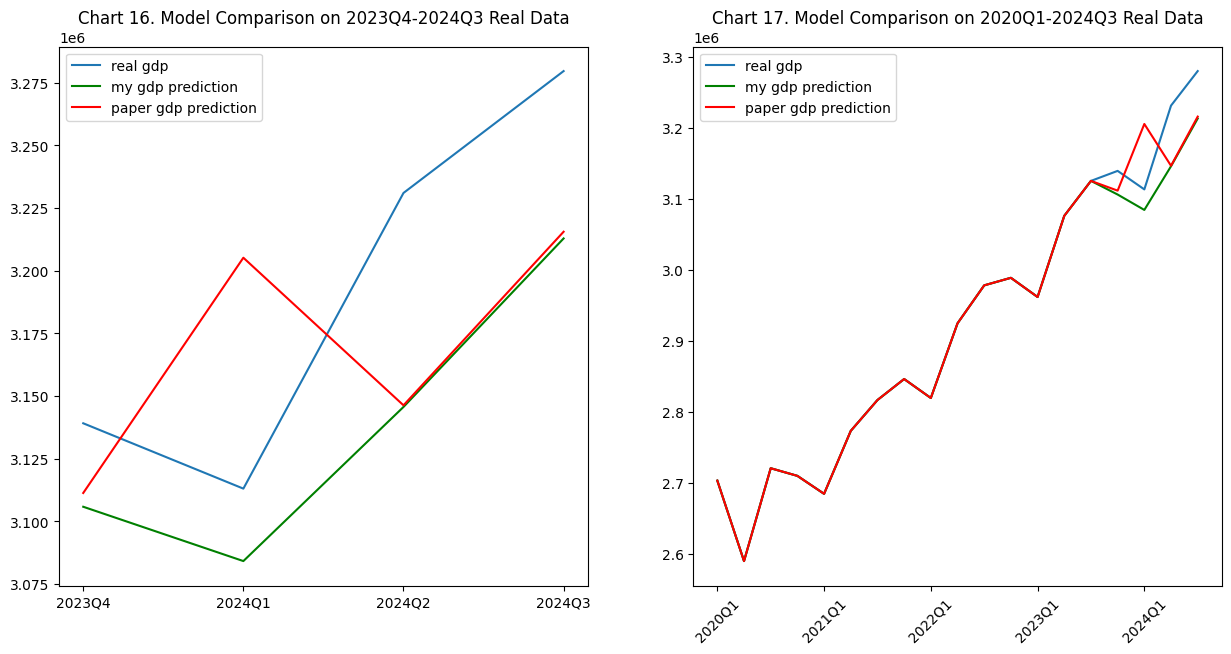

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
x_axis = df_test["period"].astype("str")

ax[0].plot(x_axis, real_gdp, label="real gdp")
ax[0].plot(x_axis, my_prediction.to_list(), label="my gdp prediction", color="green")
ax[0].plot(x_axis, paper_prediction, label="paper gdp prediction", color="red")
ax[0].set_title("Chart 16. Model Comparison on 2023Q4-2024Q3 Real Data")
ax[0].legend()

df_gdp_real_2020_2023 = df_gdp_real_2014_2023[df_gdp_real_2014_2023["period"]>"2019Q4"]
combined_x_axis = df_gdp_real_2020_2023["period"].astype("str").to_list() + x_axis.to_list()

ax[1].plot(combined_x_axis, df_gdp_real_2020_2023["gdp"].to_list() + list(real_gdp), label="real gdp")
ax[1].plot(combined_x_axis, df_gdp_real_2020_2023["gdp"].to_list() + my_prediction.to_list(), label="my gdp prediction", color="green")
ax[1].plot(combined_x_axis, df_gdp_real_2020_2023["gdp"].to_list() + list(paper_prediction), label="paper gdp prediction", color="red")
ax[1].legend()
ax[1].set_xticks(ticks=combined_x_axis[::4],
                 labels=combined_x_axis[::4],
                 rotation=45)
ax[1].set_title("Chart 17. Model Comparison on 2020Q1-2024Q3 Real Data")


plt.show()

Objectively, my model seem to be doing better at certain metrics and prediction.

In [84]:
gdp_2024_prediction = prediction_5_step[1:].sum()

gdp_2023_real = df_gdp_real_2014_2023[df_gdp_real_2014_2023["period"]>"2022Q4"]["gdp"].to_list()
gdp_2023_q4 = prediction_5_step.iloc[0]
gdp_2023_real_and_prediction = np.array(gdp_2023_real + [gdp_2023_q4]).sum()
growth = ((gdp_2024_prediction - gdp_2023_real_and_prediction)/gdp_2023_real_and_prediction)*100 

print(f"My 2024 GDP Prediction: {gdp_2024_prediction}")
print(f"My 2023 GDP Real and Prediction: {gdp_2023_real_and_prediction}")
print(f"My 2023-2024 GDP Growth: {growth} %")
print(f"Paper 2023-2024 GDP Growth: 3.245 %")

My 2024 GDP Prediction: 12636775.838909294
My 2023 GDP Real and Prediction: 12268092.449110173
My 2023-2024 GDP Growth: 3.005221808756936 %
Paper 2023-2024 GDP Growth: 3.245 %


While my model predicts even worse annual GDP growth, they do not differ by much. Note that the real 2023-2024 Growth is, at the time of writing, not yet available.

# Discussions

#### Disclaimer
This notebook certainly is not an attempt to critize, let alone deprecate the paper. In the end, it's essentially a learning opportunity to me to critically read scientific paper, while simultaneously sharpening my time series analysis skill.

#### Findings

1) I managed to replicate nearly all the preprocessing part of the model building up until the ACF and PACF data.
2) Even under numerous iterations and modellings, I did not manage to get the same best $SARIMA$ model
    1) Based on AIC scores, which was also used in the paper, I got $SARIMA(2,1,2)(1,0,1)^{4}$ instead of the paper's $SARIMA(2,1,2)(1,0,0)^{4}$
    2) Whereas the paper's did not include Moving Average (MA) process, my model suggested that there is such process within the quarterly seasonality, which made sense considering that the pandemic basically messed the economy, making certain random noises everywhere.
    3) I managed to get better scores in MAE, MSE, RMSE, R-squared, and MAPE when tested on novel real data (2023Q4 - 2024Q3).
3) The paper considered the first difference data to be stationary, but I argued that the first difference data is actually still not stationary due to the increasing seasonality trend.
4) On a positive note, both my and the paper's prediction seemed to underestimate Indonesia's ability to recover after the pandemic, as they consistently predicted lower than the real novel data.

#### Recommendations for the paper
1) For replicabilty's sake, perhaps it should have specified all the steps and parameters done in preprocessing part. This is even more important if the steps are done by semi-automatic software, like Eviews.
    1) The ADF test actually contains lots of parameters to choose from, but the exact specifications are not mentioned in the paper.
    2) When i tried to fit ARIMA and SARIMA using the first difference data, the parameters did not converge. I ended up using log and z-score transformation. This might be due to difference in software used, but I suspected that Eviews has done certain internal transformation to the data, which was not reported in the paper.
2) Small typo found on page 85, the best model specification at the bottom is supposed to be $SARIMA(2,1,2)(1,0,1)^{4}$ instead of $SARIMA(2,1,1)(1,0,1)^{4}$. 